# Donnée Static Grid Model

1. Accès au dataset des lignes françaises du GRT RTE en date de 2019. Données en accès : I_max saisonniers, stations, longueurs, caractéristiques
Source : https://www.services-rte.com/en/learn-more-about-our-services/static-grid-model.html
Problèmes éventuels : données lacunaire et datées (2019)

2. Dataset : [Lignes aériennes RTE – nouveau découpage (au 10 juin 2024)](https://odre.opendatasoft.com/explore/dataset/lignes-aeriennes-rte-nv/information/?disjunctive.etat&disjunctive.tension&dataChart=eyJxdWVyaWVzIjpbeyJjaGFydHMiOlt7InR5cGUiOiJjb2x1bW4iLCJmdW5jIjoiQ09VTlQiLCJ5QXhpcyI6ImxvbmdpdHVkZV9kZWJ1dF9zZWdtZW50Iiwic2NpZW50aWZpY0Rpc3BsYXkiOnRydWUsImNvbG9yIjoicmFuZ2UtQWNjZW50In1dLCJ4QXhpcyI6InRlbnNpb24iLCJtYXhwb2ludHMiOm51bGwsInNvcnQiOiIiLCJzZXJpZXNCcmVha2Rvd24iOiJldGF0Iiwic2VyaWVzQnJlYWtkb3duVGltZXNjYWxlIjoiIiwiY29uZmlnIjp7ImRhdGFzZXQiOiJsaWduZXMtYWVyaWVubmVzLXJ0ZS1udiIsIm9wdGlvbnMiOnsiZGlzanVuY3RpdmUuZXRhdCI6dHJ1ZSwiZGlzanVuY3RpdmUudGVuc2lvbiI6dHJ1ZX19fV0sInRpbWVzY2FsZSI6IiIsImRpc3BsYXlMZWdlbmQiOnRydWUsImFsaWduTW9udGgiOnRydWV9&location=13,45.56282,4.83351&basemap=jawg.light) / 

## Importations de librairie

In [98]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import json 
import seaborn as sns
import utm

import plotly.express as px
import plotly.graph_objects as go

from sklearn.cluster import DBSCAN
from sklearn.linear_model import LinearRegression

from utils import *

import os

## DATA Lignes

### Ligne 2019 + caractéristiques : THT

#### Ouvrir le dataset

In [99]:
path = '/Users/matthiasmolenat/repos/congestion/data/RT_ligne_2019.csv'
df_ligne_RT_2019 = pd.read_csv(path,delimiter=';', decimal=',',index_col=False)
df_ligne_RT_2019.drop('Unnamed: 14', axis = 1, inplace=True)
df_ligne_RT_2019.head()

,ref,Circuit name,sub_1_short,sub_2_short,Voltage level (kV),I_max_Summer,I_max_Interseason_1,I_max_Interseason_2,I_max_Winter,Resistance R (Ω),Reactance X (Ω),Capacity (nF),Half-Susceptance Hd/2 (μS),Length (m)
0,AIRVAL61BONN6,LIT 225kV N0 1 AIRVAULT-BONNEAU,AIRVA,BONN6,225,932.0,932.0,1145.0,1145.0,3.064,20.350,762.736,119.810,52792
1,AIRVAL61JUMEA,LIT 225kV N0 1 AIRVAULT-JUMEAUX (LES),AIRVA,JUMEA,225,1249.0,1337.0,1337.0,1434.0,0.330,2.212,50.501,7.933,5507
2,ALBERL61CHAV6,LIT 225kV N0 1 ALBERTVILLE-CHAVANOD,ALBER,CHAV6,225,617.0,685.0,685.0,742.0,4.460,17.210,17.210,60.000,42135
3,ALBERL61CONTA,LIT 225kV N0 1 ALBERTVILLE-CONTAMINE,ALBER,CONTA,225,565.0,673.0,673.0,765.0,2.352,10.043,225.097,35.358,24925
4,ALBERL61LONG6,LIT 225kV N0 1 ALBERTVILLE-LONGEFAN,ALBER,LONG6,225,565.0,673.0,673.0,765.0,4.486,17.749,391.180,61.446,43669


In [100]:
print(f'Shapde : {df_ligne_RT_2019.shape}')
print(f'Column names : {df_ligne_RT_2019.columns}')

Shapde : (921, 14)
Column names : Index(['ref', 'Circuit name', 'sub_1_short', 'sub_2_short',
       'Voltage level (kV)', 'I_max_Summer', 'I_max_Interseason_1',
       'I_max_Interseason_2', 'I_max_Winter', 'Resistance R (Ω)',
       'Reactance X (Ω)', 'Capacity (nF)', 'Half-Susceptance Hd/2 (μS)',
       'Length (m)'],
      dtype='object')


#### Remplacer les nan values dans les lignes s'il existe un doublon fourni en information.

In [101]:
# Group by the columns `sub_1_short`, `sub_2_short`, and `Voltage level (kV)`
group_cols = ['sub_1_short', 'sub_2_short', 'Voltage level (kV)']
df_filled = (
    df_ligne_RT_2019.groupby(group_cols)
    .apply(lambda group: group.ffill().bfill() , include_groups=False)
)
# Remove the multi-index introduced by `groupby().apply()`
df_ligne_RT_2019 = df_filled.reset_index(drop=False)

#### Drop les lignes de taille nulle

In [102]:
df_ligne_RT_2019 =  df_ligne_RT_2019[df_ligne_RT_2019['Length (m)'] > 0]
print(f'Number of Nan values : {df_ligne_RT_2019.isna().sum().sum()}')

Number of Nan values : 32


#### Drop les nans restants

In [103]:
df_ligne_RT_2019.dropna(inplace=True)

#### Visualisation : Lignes associées à un poste

In [104]:
df_poste_spe = get_row_with_str(df_ligne_RT_2019, 'MONTEUX')
df_poste_spe.head(20)

,sub_1_short,sub_2_short,Voltage level (kV),level_3,ref,Circuit name,I_max_Summer,I_max_Interseason_1,I_max_Interseason_2,I_max_Winter,Resistance R (Ω),Reactance X (Ω),Capacity (nF),Half-Susceptance Hd/2 (μS),Length (m)
92,B.MON,CHAFF,400,804,B.MONL72CHAFF,LIT 400kV N0 2 BEAUMONT-MONTEUX - CHAFFARD (LE),3465.0,3544.0,3544.0,3575.0,2.261,22.922,903.910,141.986,75994
93,B.MON,COULA,400,805,B.MONL72COULA,LIT 400kV N0 2 BEAUMONT-MONTEUX - COULANGE,3465.0,3544.0,3544.0,3575.0,1.715,19.416,710.500,111.605,61247
94,B.MON,GAMPA,225,480,B.MONL62GAMPA,LIT 225kV N0 2 BEAUMONT-MONTEUX-GAMPALOUP,880.0,992.0,992.0,1086.0,2.170,14.700,331.537,52.000,36312
95,B.MON,VALE8,225,58,B.MONL61VALE8,LIT 225kV N0 1 BEAUMONT-MONTEUX-VALENCE,695.0,782.0,782.0,855.0,1.170,5.760,80.242,23.000,14022


#### Ajout de colonnes types

In [105]:
df_ligne_RT_2019['P_max_summer (MW)']=df_ligne_RT_2019['Voltage level (kV)']*df_ligne_RT_2019['I_max_Summer']/1000
df_ligne_RT_2019['R/length'] = df_ligne_RT_2019['Resistance R (Ω)'] / df_ligne_RT_2019['Length (m)'] 

#### Récupération de donnée types :

On cherche à obtenir des grandeurs type de caractéristiques physiques pour compléter des données lacunaires. 

Hypothèse : Pour un type de ligne donné (voltage level), les grandeurs :
- $\frac{resistance}{longueur}$,
- $\frac{reactance}{longueur}$,

se conserve. 

Une étude supplémentaire doit être mené pour la valeur de $I_{max}$

##### Résistances & réactances

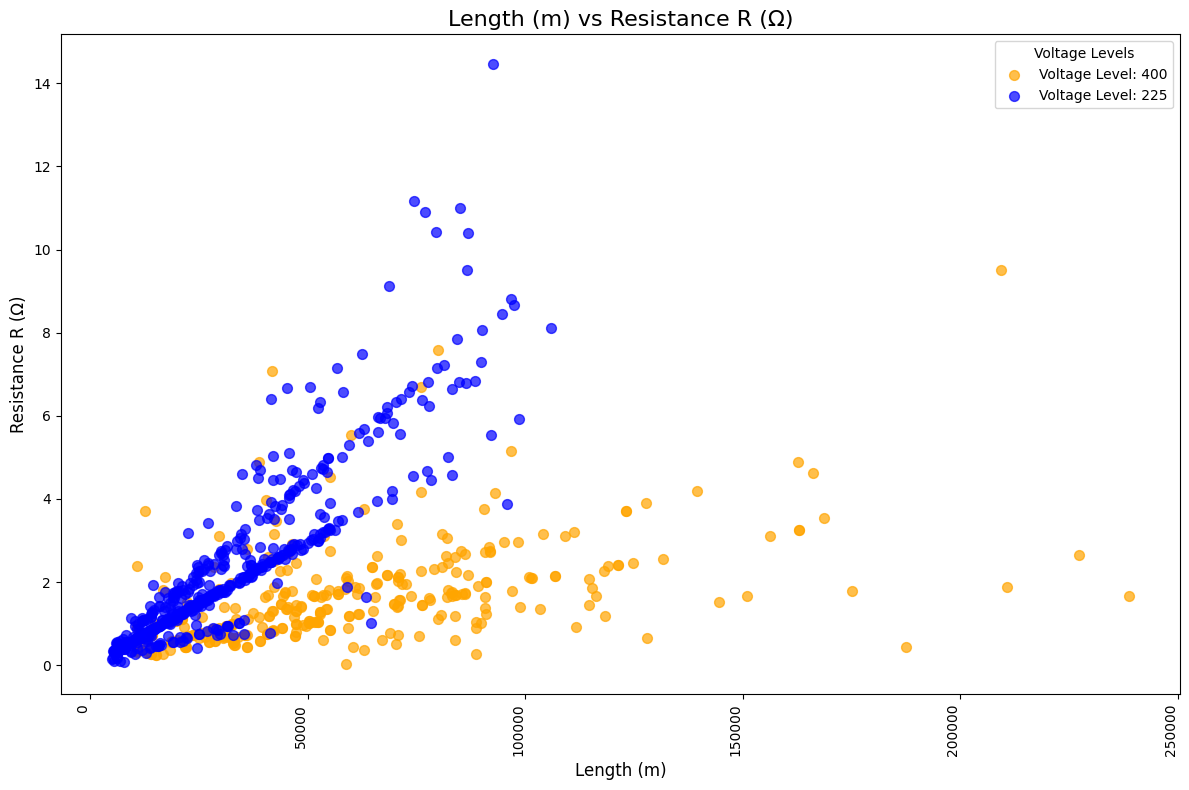

In [106]:
# Define colors for the two voltage levels
colors = {'225': 'blue', '400': 'orange'} 
X_name = 'Length (m)'
Y_name = 'Resistance R (Ω)'
scatter_plot(df_ligne_RT_2019, colors, X_name, Y_name)

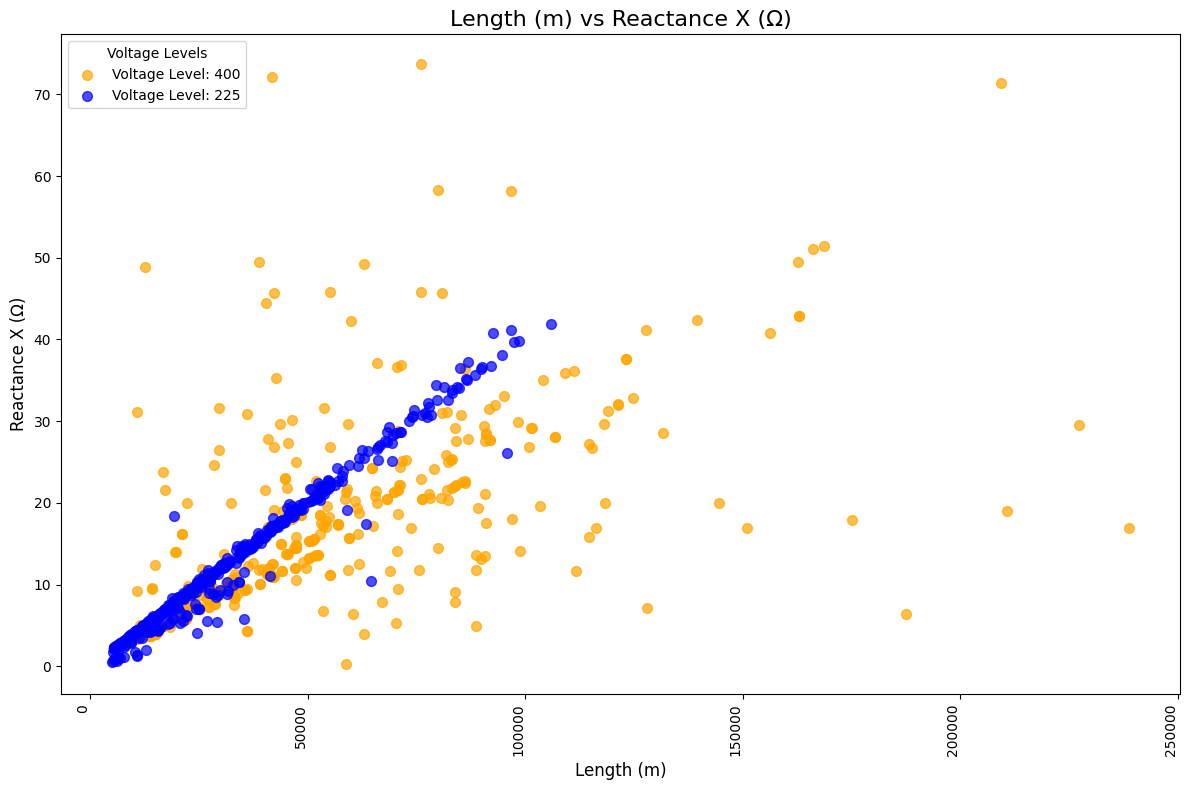

In [107]:
# Define colors for the two voltage levels
colors = {'225': 'blue', '400': 'orange'} 
X_name = 'Length (m)'
Y_name = 'Reactance X (Ω)'
scatter_plot(df_ligne_RT_2019, colors, X_name, Y_name)

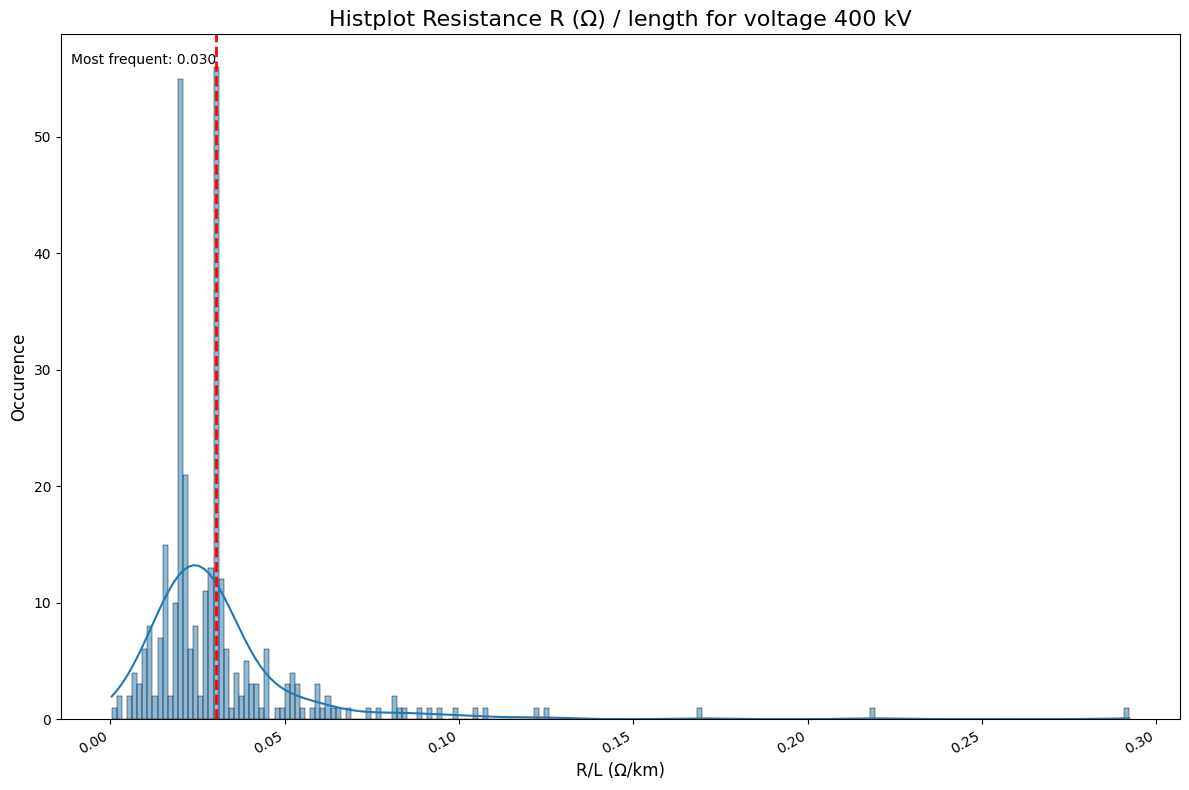

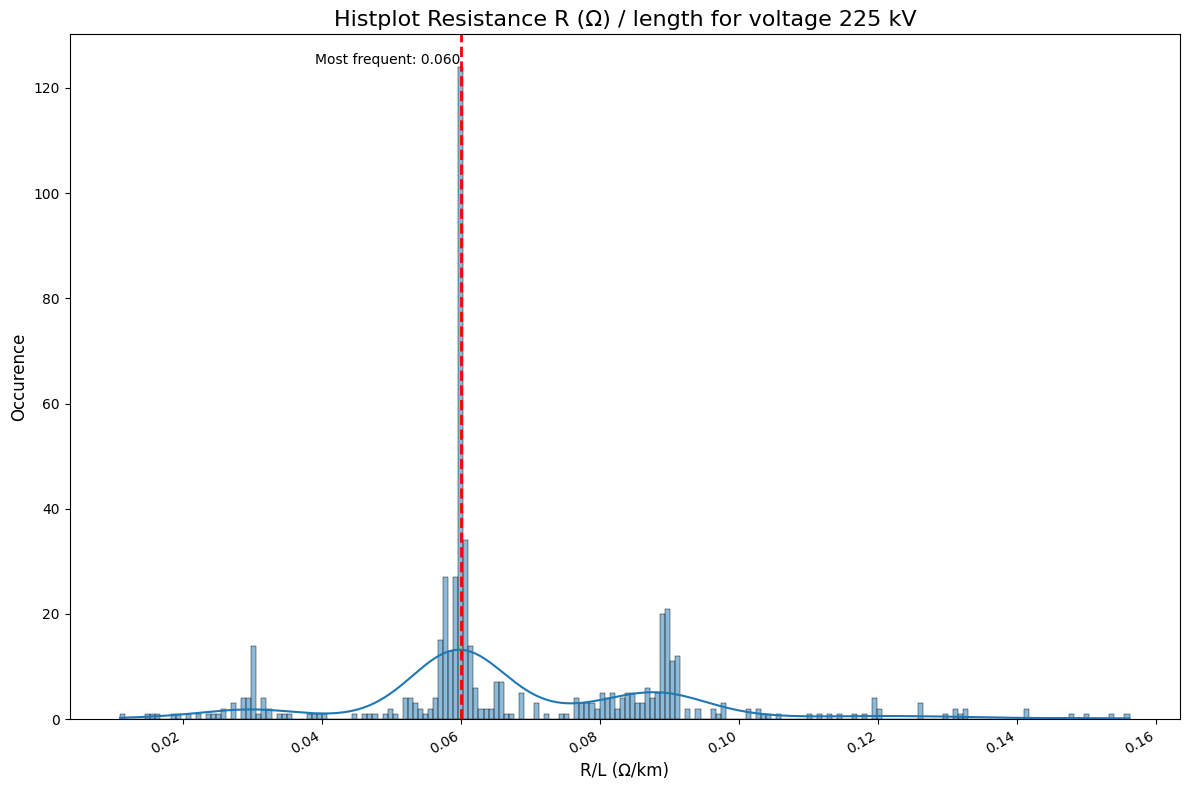

In [108]:
list_col =  ['Resistance R (Ω)', 'R/L (Ω/km)' ]
hist_plot_1(df_ligne_RT_2019, list_col)

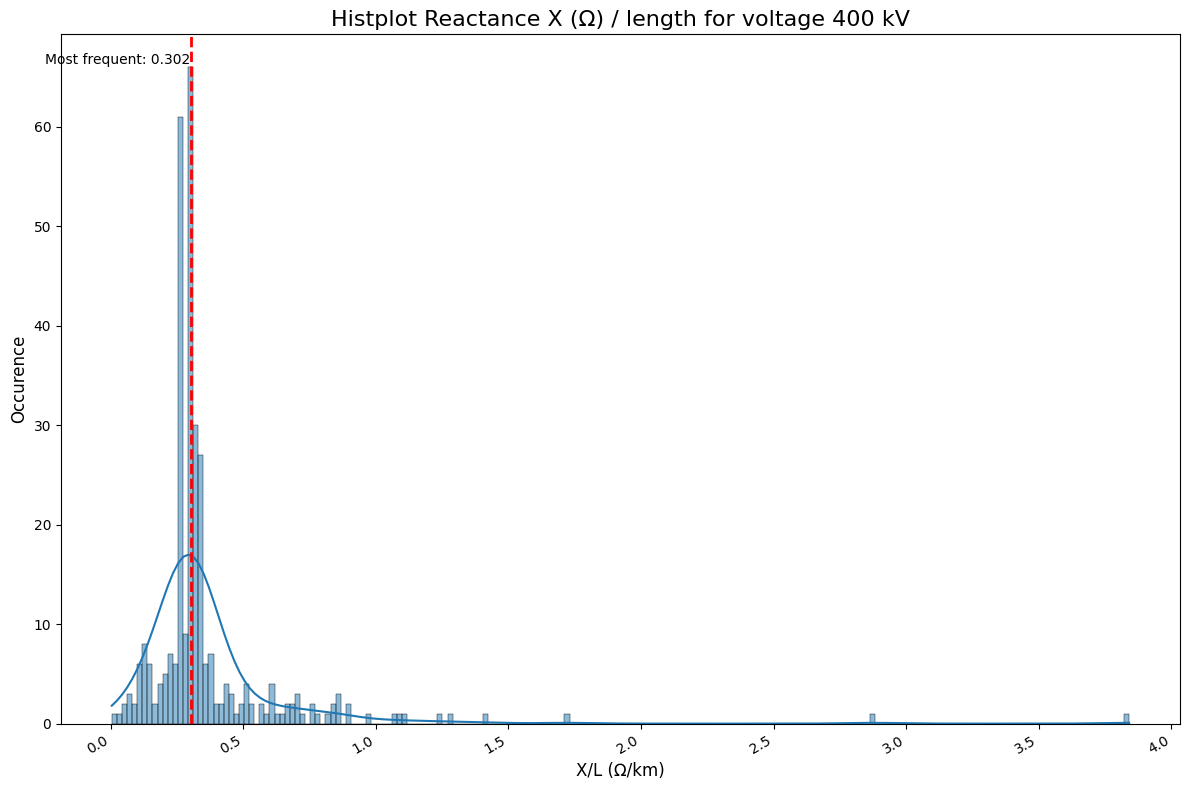

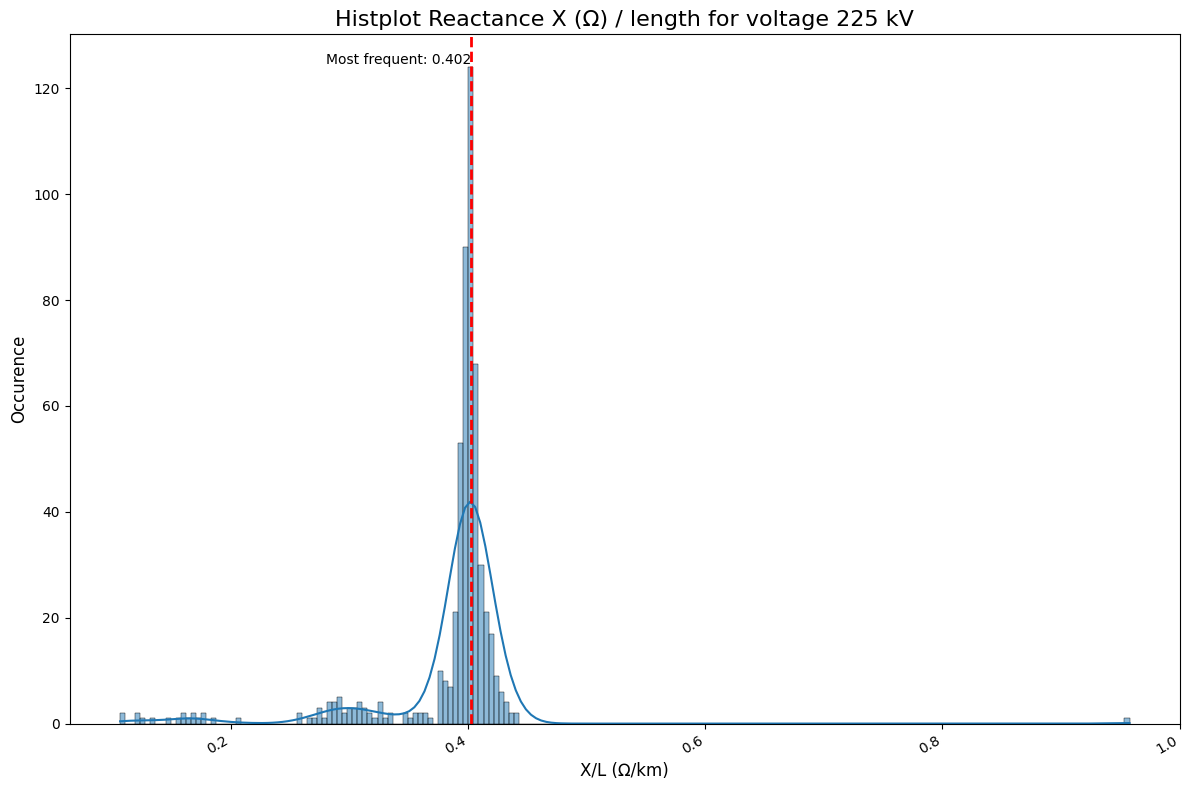

In [109]:
list_col =  ['Reactance X (Ω)', 'X/L (Ω/km)' ]
hist_plot_1(df_ligne_RT_2019, list_col)

##### Courant max :

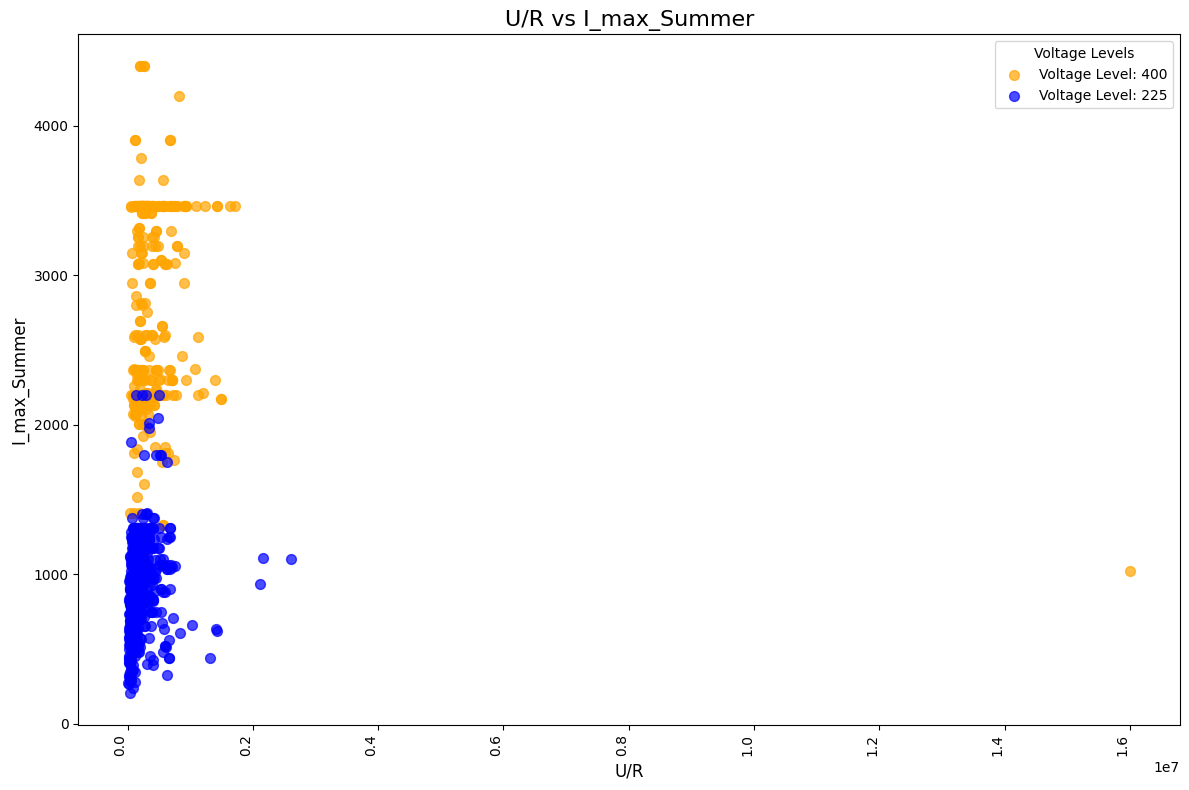

In [110]:
df_ligne_RT_2019['U/R'] = df_ligne_RT_2019['Voltage level (kV)']*1000/df_ligne_RT_2019['Resistance R (Ω)']

# Define colors for the two voltage levels
colors = {'225': 'blue', '400': 'orange'} 
X_name = 'U/R'
Y_name = 'I_max_Summer'
scatter_plot(df_ligne_RT_2019, colors, X_name, Y_name)

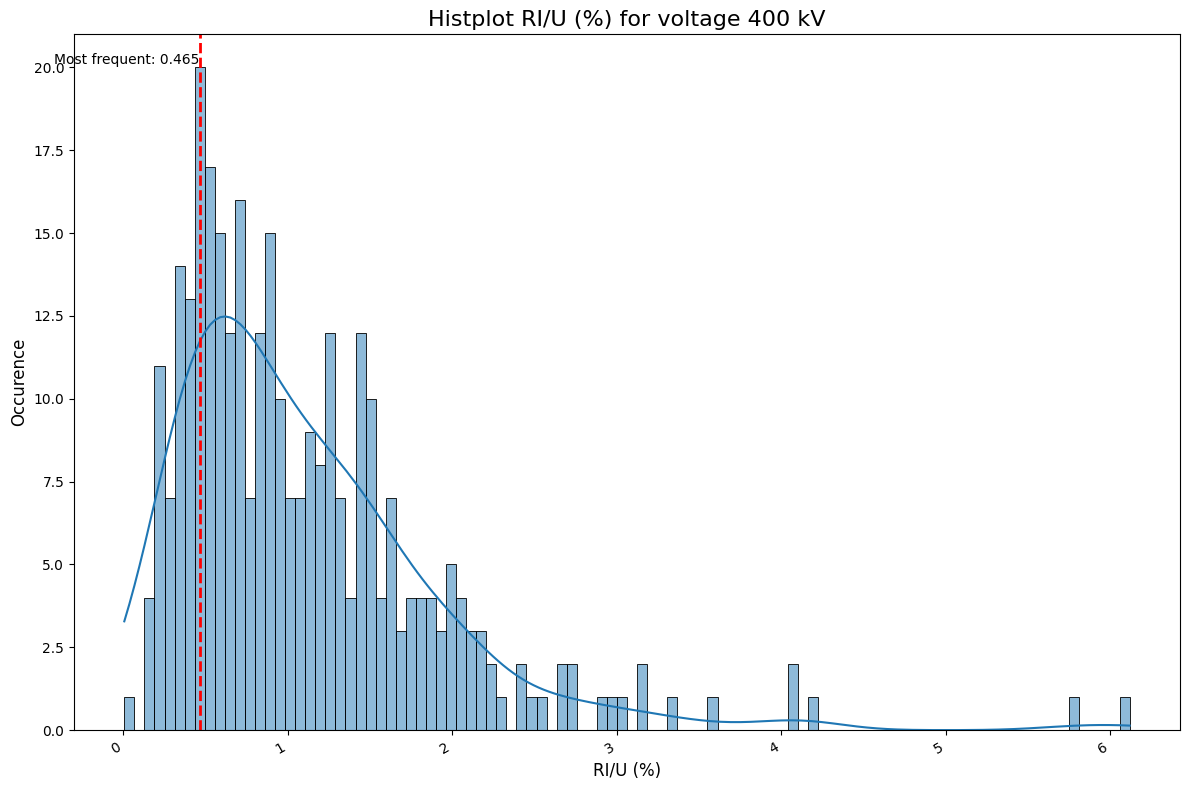

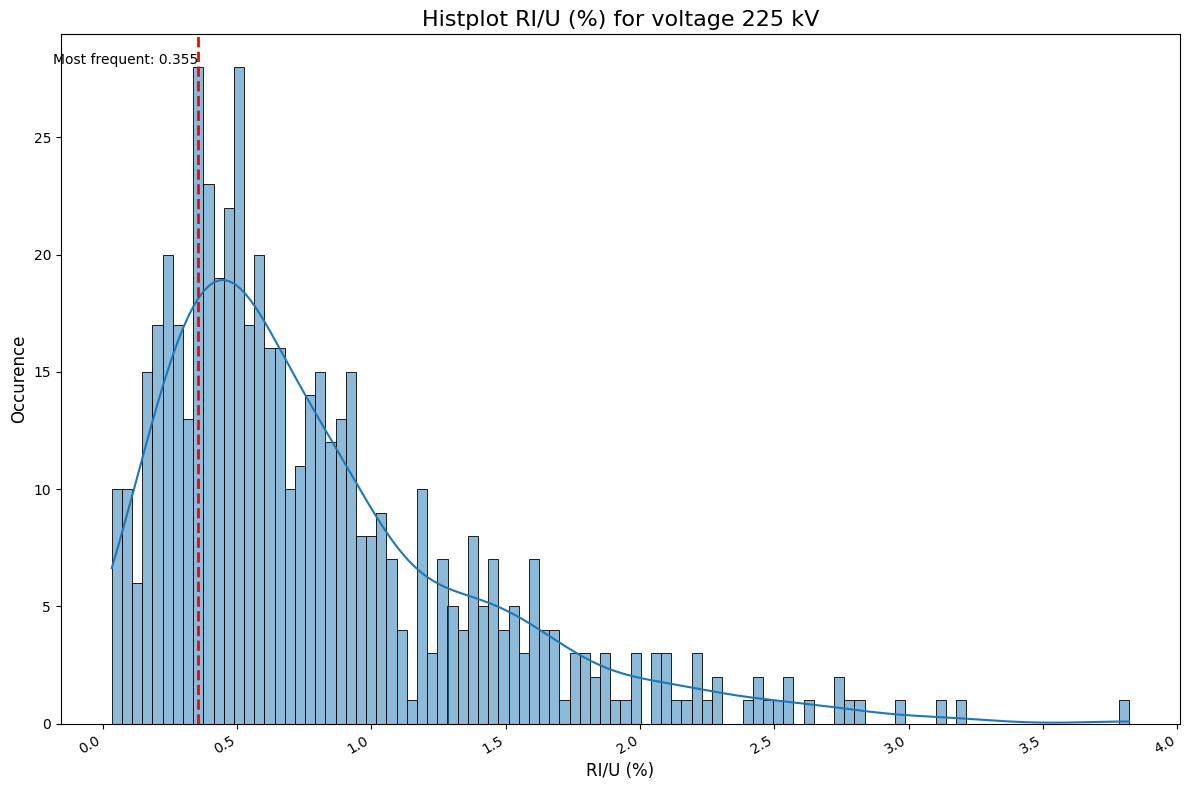

In [111]:
Y_name = 'RI/U (%)' # Pertes / Puissance transitée
df_ligne_RT_2019['RI/U (%)'] = df_ligne_RT_2019['Resistance R (Ω)']*df_ligne_RT_2019['I_max_Summer']/df_ligne_RT_2019['Voltage level (kV)']/10
hist_plot_2(df_ligne_RT_2019, Y_name)

##### Résultats :

En tant que premières bonnes approximations, on prends :

In [112]:
R_per_km_225 = 0.06 # Ohm / km
X_per_km_225 = 0.402 # Ohm / km

R_per_km_400 = 0.02 # Ohm / km
X_per_km_400 = 0.302 # Ohm / km

pertes_225 = 0.355 # %
pertes_400 = 0.465 # %


##### Commentaires : 

1. Pour la modélisation des lignes, on observe dans certains cas deux types distincts et de poids équivalent. Plusieurs choix possibles : moyenne, définitions de deux modèles, etc.
2. On retrouve les chiffres R/L et X/L avancés dans https://www.techno-science.net/definition/6745.html
3. intensité max : on suppose un ratio de perte autorisé max sur la ligne. $ratio = \frac{Pertes = RI^2}{Transmis = UI}$. A Approfondir? 

### Lignes 2024 

In [113]:
path_ligne_aer = '/Users/matthiasmolenat/repos/congestion/data/lignes-aeriennes-rte-nv.csv'
df_ligne_RT_2023 = pd.read_csv(path_ligne_aer,delimiter=';')


In [114]:
df_ligne_RT_2023.groupby('TENSION').count()

,Type ouvrage,Code ligne 1,Nom ligne 1,Propriétaire ligne 1,Etat,Source donnée,Geo Shape,Nombre circuit,Code ligne 2,Nom ligne 2,...,Code ligne 3,Nom ligne 3,Propriétaire ligne 3,Code ligne 4,Nom ligne 4,Propriétaire ligne 4,Code ligne 5,Nom ligne 5,Proprietaire ligne 5,geo_point_2d
TENSION,,,,,,,,,,,,,,,,,,,,,
150kV,68,68,68,68,68,68,68,68,6,6,...,0,0,0,0,0,0,0,0,0,68
225kV,2973,2973,2972,2972,2973,2973,2973,2973,697,697,...,17,17,17,7,7,7,1,1,1,2973
400kV,1075,1075,1073,1075,1075,1075,1075,1075,247,247,...,3,3,3,2,2,2,0,0,0,1075
45kV,99,99,99,99,99,99,99,99,13,13,...,0,0,0,0,0,0,0,0,0,99
63kV,6083,6083,6077,6083,6083,6083,6083,6083,1138,1135,...,1,1,1,0,0,0,0,0,0,6083
90kV,2646,2646,2646,2646,2646,2646,2646,2646,534,534,...,1,1,1,0,0,0,0,0,0,2646
<45kV,7,7,7,7,7,7,7,7,0,0,...,0,0,0,0,0,0,0,0,0,7
HORS TENSION,259,259,256,259,259,259,259,259,18,18,...,0,0,0,0,0,0,0,0,0,259


In [115]:
df_ligne_RT_2023.shape

(13210, 22)

#### Calcul de la longueur des lignes

In [116]:
geo_shape_index = df_ligne_RT_2023.columns.to_list().index("Geo Shape")

for index, row in df_ligne_RT_2023.iterrows():
    geo_data = json.loads(row['Geo Shape'])
    longitudes, latitudes = zip(*geo_data["coordinates"])
    df_ligne_RT_2023.at[index, "Length (m)"] = length_from_coordinate(longitudes, latitudes )
    
df_ligne_RT_2023.head()

,Type ouvrage,Code ligne 1,Nom ligne 1,Propriétaire ligne 1,Etat,TENSION,Source donnée,Geo Shape,Nombre circuit,Code ligne 2,...,Nom ligne 3,Propriétaire ligne 3,Code ligne 4,Nom ligne 4,Propriétaire ligne 4,Code ligne 5,Nom ligne 5,Proprietaire ligne 5,geo_point_2d,Length (m)
0,AERIEN,ROLAML61ZRIGO,LIAISON 225kV N0 1 PUSY - RIGOTTE (LA) - ROLAM...,MAINTENU PAR ET PROPRIETE RTE,EN EXPLOITATION,225kV,RTE,"{""coordinates"": [[5.7085749089, 47.7587819641]...",1,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"47.82855513836, 5.491070148827368",37585.062294
1,AERIEN,CEBAZL31RIOM,LIAISON 63kV N0 1 CEBAZAT-RIOM,MAINTENU PAR ET PROPRIETE RTE,EN EXPLOITATION,63kV,RTE,"{""coordinates"": [[3.1228486356, 45.8837232437]...",1,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"45.883755153600006, 3.12276277745",15.099487
2,AERIEN,CROIXL62P.ME5,LIAISON 225kV N0 2 CROIX (LA) - PETIT-MENIN,MAINTENU PAR ET PROPRIETE RTE,EN EXPLOITATION,225kV,RTE,"{""coordinates"": [[3.1302285506, 50.7103537288]...",1,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"50.71040177335, 3.1305627690499995",48.409100
3,AERIEN,COULAL71TAVEL,LIAISON 400kV N0 1 COULANGE - TAVEL,MAINTENU PAR ET PROPRIETE RTE,EN EXPLOITATION,400kV,RTE,"{""coordinates"": [[4.7217727214, 44.6325603872]...",1,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"44.632447227149996, 4.72240015955",102.700548
4,AERIEN,ARGE8L41GACE,LIAISON 90kV N0 1 ARGENTAN-GACE,MAINTENU PAR ET PROPRIETE RTE,EN EXPLOITATION,90kV,RTE,"{""coordinates"": [[-0.0089275157, 48.7425637902...",2,ARGE8L41VASTO,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"48.77603848796921, 0.01729029857262007",9580.258926


#### Ligne avec nom de poste

In [117]:
df_poste_spe = get_row_with_str(df_ligne_RT_2023, 'B.MONL72CHAFF')
df_poste_spe.head(20)

,Type ouvrage,Code ligne 1,Nom ligne 1,Propriétaire ligne 1,Etat,TENSION,Source donnée,Geo Shape,Nombre circuit,Code ligne 2,...,Nom ligne 3,Propriétaire ligne 3,Code ligne 4,Nom ligne 4,Propriétaire ligne 4,Code ligne 5,Nom ligne 5,Proprietaire ligne 5,geo_point_2d,Length (m)
450,AERIEN,B.MONL72CHAFF,LIAISON 400kV N0 2 BEAUMONT-MONTEUX - CHAFFARD...,MAINTENU PAR ET PROPRIETE RTE,EN EXPLOITATION,400kV,RTE,"{""coordinates"": [[4.9300613913, 45.0240507591]...",1,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"45.02210622132258, 4.929674506272831",434.501656
3107,AERIEN,B.MONL72CHAFF,LIAISON 400kV N0 2 BEAUMONT-MONTEUX - CHAFFARD...,MAINTENU PAR ET PROPRIETE RTE,EN EXPLOITATION,400kV,RTE,"{""coordinates"": [[5.1203501995, 45.6615082429]...",1,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"45.66165405095, 5.120766275349999",72.501180
11143,AERIEN,CHAFFL71COULA,LIAISON 400kV N0 1 CHAFFARD (LE) - COULANGE,MAINTENU PAR ET PROPRIETE RTE,EN EXPLOITATION,400kV,RTE,"{""coordinates"": [[5.1203501995, 45.6615082429]...",2,B.MONL72CHAFF,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"45.35973657777207, 4.988585428824228",75645.757872


### Extrapolation caractéristiques éléctrotechniques 2024 depuis les lignes 2019

## DATA Postes 

### DATA Postes : CAPARESEAUX

Capacté d'acceuil .csv issu de https://www.capareseau.fr/

[Données intéressantes](https://www.services-rte.com/fr/decouvrez-nos-offres-de-services/consulter-les-capacites-d-accueil-du-reseau-capareseau.html):

A l'injection :
1. Taux d'affectation des capacités  (%), part des capacités réservées du S3REnR attribuée à des installations EnR en développement ou en service. Il correspond au taux d’avancement global du schéma.

Au sous-tirage :
1. consommation minimale ( = été? en hiver, = x5 ?)

A l'injection et au sous-tirage :
1. Puissance cumulee des transformateurs existants das le poste source (MW)
2. Travaux indiqués dans le schéma ou dans son état initial

Pour la modélisation du réseau :
1. Tension amont du poste source (GRT, kV),
2. Tension aval du poste source (GRD, kV),


In [118]:
path_capa = '/Users/matthiasmolenat/repos/congestion/data/CapacitesDAccueil.csv'
df_capareseau = pd.read_csv(path_capa,delimiter=';')
df_capareseau = df_capareseau[df_capareseau.columns[~df_capareseau.columns.str.endswith('.1')]]
df_capareseau = df_capareseau[df_capareseau["Puissance cumulee des transformateurs existants"] > 0]
df_capareseau = df_capareseau[df_capareseau['Consommation minimale'] > 0]

 
df_capareseau = df_capareseau[~df_capareseau["Capacite de transformation HTB/HTA restante disponible pour l'injection sur le reseau public de distribution"].isna()]
df_capareseau = df_capareseau[df_capareseau["Capacite de transformation HTB/HTA restante disponible pour l'injection sur le reseau public de distribution"]>0]

df_capareseau = df_capareseau[~df_capareseau["Consommation minimale"].isna()]

df_capareseau.shape

(2223, 35)

#### Visualisation d'une ligne en particulière

In [119]:
df_poste_spe = get_row_with_str(df_capareseau, 'CHAP5')

for i,x in enumerate(df_poste_spe.columns.to_list()):
    print(f'\n {x} : {df_poste_spe.iloc[0][x]}')


 Code : CHAP5

 Nom : LA CHAPELLE

 S3REnR : CENTRE

 Taux d'affection des capacite?s re?serve?es : 75%

 X : 503893.3

 Y : 6692548.5

 Puissance des projets en service du S3REnR en cours : 0.6

 Puissance des projets en developpement du S3REnR en cours : 4.5

 Capacite d'accueil reservee au titre du S3REnR qui reste e affecter : 1.9

 Puissance EnR deje raccordee : 11.5

 Puissance des projets EnR en developpement : 12.3

 Capacite reservee aux EnR au titre du S3REnR : 7.0

 Attention: la valeur de la capacite reservee a ete modifiee sur ce poste : Transfert -4 MW 19/06/24

 Quote-Part unitaire actualisee : 62.75 k€/MW

 Attention : Le S3REnR de la region est sature : nan

 dont la convention de raccordement est signee : 0.0

 Capacite d'accueil reservee au titre du S3REnR, disponible vue du reseau public de transport  : 0.0

 Travaux RTE indiques dans le schema ou dans son etat initial, permettant d'augmenter la capacite reservee disponible : nan

 RTE - Capacite d'accueil en HTB2 

#### Visualisation de la répartition des conso minimales 

Guess : poche de sous-tirage = p_max = p_min * 5 / p_inst, french heatmap

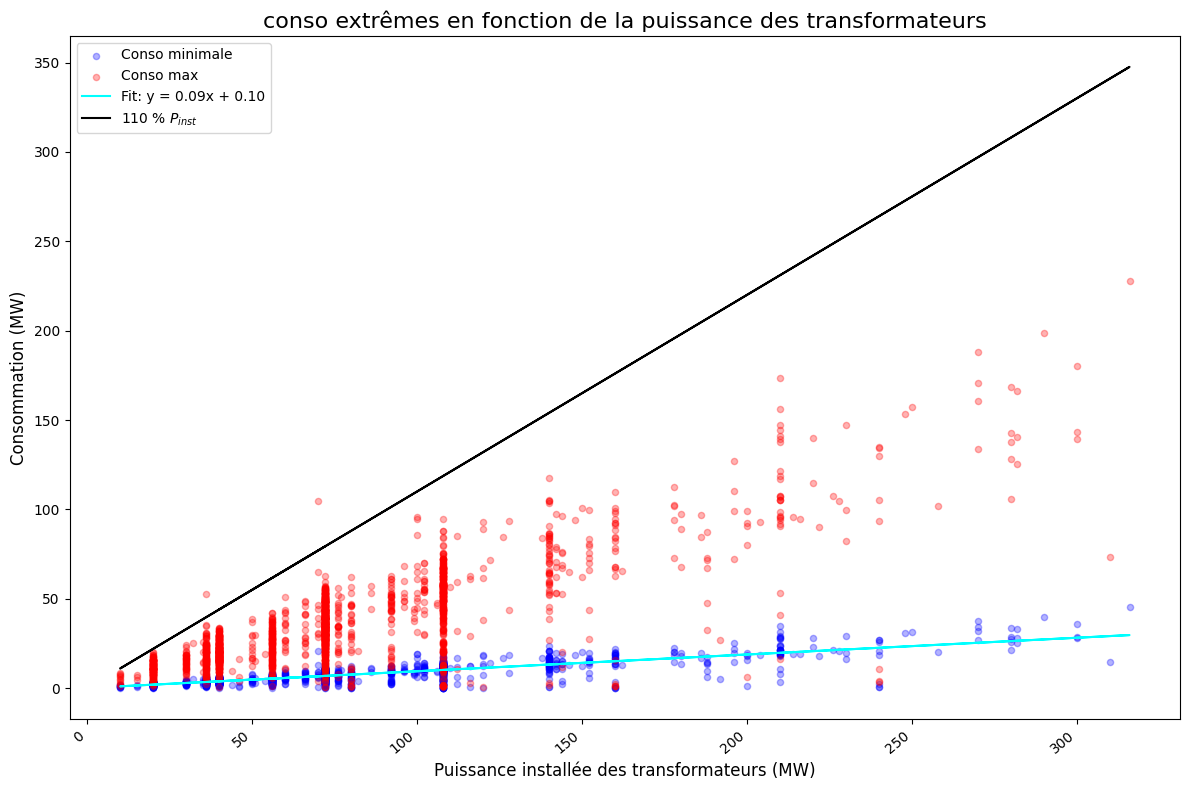

In [120]:
X_name = "Puissance cumulee des transformateurs existants"
Y_name = "Consommation minimale"

df = df_capareseau[[X_name,Y_name]].copy()
df.dropna(inplace=True)

x = df[X_name]
y_min = df[Y_name]
y_max = 5*df[Y_name]

lim_acceptable = 110/100

coefficients = np.polyfit(x, y_min, 1)  # Fit a line: y = mx + c
m, c = coefficients
y_fit = m * x + c  # Regression line values

plt.figure(figsize=(12, 8))

plt.scatter(x, y_min, 
            s=20, alpha=0.3, c = 'b', label = 'Conso minimale')
plt.scatter(x, y_max,
            s=20, alpha=0.3, c = 'r', label = 'Conso max')

plt.plot(x, y_fit, label=f"Fit: y = {m:.2f}x + {c:.2f}", color="cyan")
plt.plot(x, lim_acceptable*x, label="110 % $P_{inst}$", color="black") # 110 %

# Customize the plot
plt.title(f'conso extrêmes en fonction de la puissance des transformateurs', fontsize=16)
plt.ylabel('Consommation (MW)', fontsize=12)
plt.xlabel('Puissance installée des transformateurs (MW)', fontsize=12)
plt.legend()
plt.xticks(rotation=40, ha='right')

plt.tight_layout()

# Display the plot
plt.show()

### Data Postes : ODRE

Fichier [Enceintes de poste RTE (au 10 juin 2024)](https://odre.opendatasoft.com/explore/dataset/enceintes-de-poste-rte/export/?disjunctive.etat&sort=nom_poste)

Pour, dans un premier temps, récupérer les coordonnées des postes caparéseaux ouverts précédemment

In [121]:
path_postes = '/Users/matthiasmolenat/repos/congestion/data/enceintes-de-poste-rte.csv'
df_poste_odre = pd.read_csv(path_postes,delimiter=';')

In [122]:
df_poste_odre.groupby('TENSION MAXIMALE').count()

,﻿NOM POSTE,Etat,CLASSE PRECISION,Source donnée,CODIFICATION NATIONALE POSTE,Geo Shape (DD),geo_point_2d
TENSION MAXIMALE,,,,,,,
150kV,35,35,35,35,35,35,35
225kV,808,808,808,808,808,808,808
400kV,175,175,175,175,175,175,175
45kV,33,33,33,33,33,33,33
63kV,2086,2086,2086,2086,2086,2084,2084
90kV,811,811,811,811,811,811,811
<45kV,19,19,19,19,19,19,19
COURANT CONTINU,1,1,1,1,1,1,1
HORS TENSION,34,34,34,34,34,34,34


### Upgrade Data Postes : ODRE + caparéseaux

Récupération des coordonnées 2D

In [123]:
df_left =  df_capareseau.set_index('Code').copy()
df_right =  df_poste_odre.set_index('CODIFICATION NATIONALE POSTE')['geo_point_2d'].copy()

df_joined = df_left.join(df_right, how='inner')

df_joined['geo_point_2d'] = df_joined['geo_point_2d'].astype(str)
geo_point_2d = df_joined['geo_point_2d'].to_list()


df_joined['lat'] = [x.split(sep= ', ')[0] for x in geo_point_2d]
df_joined['lon'] = [x.split(sep = ', ')[-1] for x in geo_point_2d]



In [138]:
# sous-tirage 
df_capareseau_ss_tirage = df_joined.copy()
df_capareseau_ss_tirage["ratio_congestion_sous_tirage"] = 5*df_capareseau_ss_tirage["Consommation minimale"]/df_capareseau_ss_tirage["Puissance cumulee des transformateurs existants"]*100
df_capareseau_ss_tirage = df_capareseau_ss_tirage[df_capareseau_ss_tirage["ratio_congestion_sous_tirage"]<110]
df_capareseau_ss_tirage = df_capareseau_ss_tirage[~df_capareseau_ss_tirage['ratio_congestion_sous_tirage'].isna()]
df_capareseau_ss_tirage["ratio_congestion_sous_tirage"] = df_capareseau_ss_tirage["ratio_congestion_sous_tirage"].astype(int)
df_capareseau_ss_tirage["RAM_sous_tirage"] = (1 -  df_capareseau_ss_tirage["ratio_congestion_sous_tirage"]/100)*df_capareseau_ss_tirage["Puissance cumulee des transformateurs existants"]


# injection 
df_capareseau_injection = df_joined.copy()
df_capareseau_injection["projet_injection"] = df_capareseau_injection['Puissance EnR deje raccordee'] + df_capareseau_injection["Puissance des projets EnR en developpement"] + df_capareseau_injection["Puissance en file d'attente hors S3REnR majoree de la capacite reservee du S3REnR"]
df_capareseau_injection["ratio_congestion_injection"] = df_capareseau_injection["projet_injection"]  / df_capareseau_injection["Capacite de transformation HTB/HTA restante disponible pour l'injection sur le reseau public de distribution"]*100
df_capareseau_injection["ratio_congestion_injection"] = [100 if x > 100 else x for x in df_capareseau_injection["ratio_congestion_injection"].to_list()] 
df_capareseau_injection = df_capareseau_injection[~df_capareseau_injection['ratio_congestion_injection'].isna()]
df_capareseau_injection["ratio_congestion_injection"] = df_capareseau_injection["ratio_congestion_injection"].astype(int)
df_capareseau_injection["RAM_injection"] = (1-df_capareseau_injection["ratio_congestion_injection"]/100)*df_capareseau_injection["Capacite de transformation HTB/HTA restante disponible pour l'injection sur le reseau public de distribution"]

# intersection
df_intersection = df_capareseau_injection.join(df_capareseau_ss_tirage['RAM_sous_tirage'], how='inner')
row, col = df_intersection.shape
df_intersection['min_RAM'] = [min(df_intersection['RAM_sous_tirage'].iloc[i],df_intersection['RAM_injection'].iloc[i]) for i in range(row)]

In [139]:
df_intersection.to_csv('/Users/matthiasmolenat/repos/congestion/data/capareseau_ram.csv')

## DATA Contraintes 

1. [Contraintes résiduelles prospectives sur le RPT à horizon 3 à 5 ans (à février 2024)](https://odre.opendatasoft.com/explore/dataset/contraintes-region/export/?location=7,46.18744,3.57056&basemap=jawg.light)

In [125]:
path = '/Users/matthiasmolenat/repos/congestion/data/contraintes-region.csv'
df_contraintes_sites = pd.read_csv(path,delimiter=';',index_col=False)
df_contraintes_sites.head()

,Région,Ouvrage,Nom de l'ouvrage,Puissance max de l'ouvrage,Poste 1,Pourcentage 1,Poste 2,Pourcentage 2,Poste 3,Pourcentage 3,geom,centroid
0,AUVERGNE-RHÔNE-ALPES,SSSAUL31ZSSRO,LIAISON 63kV N0 1 ENVAL-ST-PIERRE-ROCHE-ST-SAUVES,16.0,SSSAU,-48.0,VOING,-47.0,NaN,NaN,NaN,NaN
1,AUVERGNE-RHÔNE-ALPES,GATEL,GATELLIER,12.0,AURIL,-29.0,JUSSA,-29.0,GATEL,-29.0,NaN,NaN
2,AUVERGNE-RHÔNE-ALPES,ALLE5L31CIZE,LIAISON 63kV N0 1 ALLEMENT (PORTIQUE)-CIZE,1.0,ALLE5,-64.0,PAIRE,-64.0,HAUT6,-46.0,NaN,NaN
3,BOURGOGNE-FRANCHE-COMTÉ,SARRYL61SEREI,LIAISON 225kV N0 1 SARRY-SEREIN,131.0,SEREI,-15.0,AUXER,-14.0,SAUIL,-14.0,NaN,NaN
4,BOURGOGNE-FRANCHE-COMTÉ,GISSEL32VERRE,LIAISON 63kV N0 2 GISSEY-VERREY,29.0,VERRE,37.0,GISSE,-31.0,DARCE,-14.0,NaN,NaN


2. [Energies et Puissances régionales liées au contraintes (vision à février 2024)](https://odre.opendatasoft.com/explore/dataset/energies-et-puissances-regionales-liees-au-contraintes/information/)

In [126]:
path = '/Users/matthiasmolenat/repos/congestion/data/energies-et-puissances-regionales-liees-au-contraintes.csv'
df_contraintes_P = pd.read_csv(path,delimiter=';',index_col=False)
df_contraintes_P.sort_values(by='Puissance Totale à compenser', ascending= True).head(12)

,Région,Puissance ENR installée,Puissance Totale à compenser,Énergie non évacuée moyenne Printemps,Énergie non évacuée moyenne Été,Énergie non évacuée moyenne Automne,Énergie non évacuée moyenne Hiver
4,ÎLE-DE-FRANCE,953.0,0.0,0.0,0.0,0.0,0.0
11,NORMANDIE,9898.0,2.0,136.0,303.0,638.0,0.0
1,BRETAGNE,3672.0,9.0,2.0,7.0,0.0,0.0
8,AUVERGNE-RHÔNE-ALPES,13251.0,83.0,23.0,1049.0,14.0,0.0
10,PAYS DE LA LOIRE,4131.0,124.0,73.0,977.0,77.0,104.0
2,PROVENCE-ALPES-CÔTE D'AZUR,5990.0,147.0,411.0,4284.0,0.0,2.0
6,OCCITANIE,7014.0,237.0,195.0,14353.0,1271.0,462.0
7,CENTRE-VAL DE LOIRE,3664.0,490.0,4877.0,33696.0,6560.0,40500.0
9,BOURGOGNE-FRANCHE-COMTÉ,4985.0,490.0,13754.0,30485.0,5754.0,69533.0
0,GRAND EST,10008.0,498.0,6844.0,17729.0,2211.0,24013.0


## Data métropole

## Visualisation sur carte

### Visualisation Lignes

In [143]:
# Create an empty figure
fig = go.Figure()

# Param
colors_tension = {'400kV' : 'red', '225kV' : 'green',
                  '150kV' : 'blue', '90kV' : 'orange',
                  '63kV' : 'magenta', '45kV' : 'yellow',
                  '<45kV' : 'purple', 'HORS TENSION' : 'black'}
light_version = False # if true, show only starting and ending point of line

# Iterate over each row in the DataFrame
for index, row in df_ligne_RT_2023[df_ligne_RT_2023['TENSION'] == '400kV'  ].iloc[:1075].iterrows():
    # Parse the JSON string in the 'Geo Shape' column
    try:
        geo_data = json.loads(row['Geo Shape'])
    except json.JSONDecodeError:
        print(f"Error parsing JSON for row {index}. Skipping this row.")
        continue
    line_tension = row['TENSION']

    # Extract coordinates
    if "coordinates" in geo_data and isinstance(geo_data["coordinates"], list):
        longitudes, latitudes = zip(*geo_data["coordinates"])
        
        if light_version:
            longitudes = [longitudes[0], longitudes[-1]]
            latitudes = [latitudes[0], latitudes[-1]]

        # Add a trace for this line
        fig.add_trace(go.Scattermap(
            mode = "lines",
            lon = longitudes,
            lat = latitudes,
            name = f"Line {index}",  # You can replace this with a more meaningful name if available
            line = dict(width = 2),
            marker_color = colors_tension[line_tension]
        ))
    else:
        print(f"No valid coordinates found for row {index}. Skipping this row.")

# Update the layout
fig.update_layout(
    geo=dict(
        scope='europe',  # You can change this to a specific country or region
        projection_type='natural earth',
        showland=True,
        landcolor='rgb(243, 243, 243)',
        countrycolor='rgb(204, 204, 204)',
        coastlinecolor='rgb(204, 204, 204)',
        showocean=True,
        oceancolor='rgb(230, 230, 250)',
        center=dict(
            lon=longitudes[0],  # Center on the first longitude
            lat=latitudes[0]    # Center on the first latitude
        ),
    ),
    showlegend=False,
    title='Some lines in France'
    )
# Show the figure
fig.show()



### Visualisation postes capareseau

#### sous-tirage

In [128]:
fig_title = 'RAM_sous_tirage during hivernal consumption - CAPARESEAU datas'
values_title = 'RAM_sous_tirage'

df_capareseau_ss_tirage['text'] = df_capareseau_ss_tirage['Nom'] + ', Value = ' + df_capareseau_ss_tirage[values_title].astype(str) + 'MW , P_inst = ' + df_capareseau_ss_tirage['Puissance cumulee des transformateurs existants'].astype(str) + ' MW'

show_map_substation_gradient(df_capareseau_ss_tirage, values_title,fig_title,values_title, 'text', True)

#### Injections

In [129]:
fig_title = 'RAM_injection during summer - CAPARESEAU datas'
values_title = "RAM_injection"

df_capareseau_injection['text'] = df_capareseau_injection['Nom'].astype(str)  + ', value = ' + df_capareseau_injection[values_title].astype(str) + ' MW'
bar_title = values_title

show_map_substation_gradient(df_capareseau_injection,values_title,fig_title,bar_title, scale_reverse= True)

#### intersections

In [140]:
fig_title = 'Substation RAM : min injection & consumption - CAPARESEAU datas'

values_title = "min_RAM"
df_intersection['text'] = df_intersection['Nom'].astype(str)  + ', value = ' + df_intersection[values_title].astype(str) + ' MW, P_inst = ' + df_intersection['Puissance cumulee des transformateurs existants'].astype(str) + ' MW'
bar_title = values_title  + ' MW'

show_map_substation_gradient(df_intersection,values_title,fig_title,bar_title, scale_reverse= True)

#### Navigation dans les datasets  et comparaison avec D1

In [132]:
path_D1 = '/Users/matthiasmolenat/repos/congestion/data/00.Suivi D1  - Suivi_D1.csv'
df_D1 = pd.read_csv(path_D1, header=1, index_col=0)
df_D1.head()

,Nom,Région,Voltage,Validation comité,État,Priorité,Injection,Soutirage,Injection.1,Soutirage.1,...,Responsable,Capacité accueil HTB1,Date envoi D1,Semaine envoi,Date réception D1,Score Poste,GeopointPoste,Délai de raccordement (mois),Commentaire,D1 envoyés
Code,,,,,,,,,,,,,,,,,,,,,
ETREP,ETREPAGNY,HAUTE-NORMANDIE,63kV,NOGO,Reçu,NaN,0,2000,0,0,...,Pierre-Olivier,> 15.0MW,12/12/2023,Semaine 50 décembre 2023,19/03/2024,NaN,"49.31424271336771, 1.6408855863652068",NaN,NaN,1.0
CRIQU,CRIQUET,HAUTE-NORMANDIE,90kV,NOGO,Reçu,P2,0,2000,0,0,...,Pierre-Olivier,> 15.0MW,12/12/2023,Semaine 50 décembre 2023,NaN,NaN,"49.555069978156354, 0.45675836761054045",NaN,NaN,1.0
ORCHI,ORCHIES,HAUTS-DE-FRANCE,90kV,NOGO,Reçu,NaN,0,2000,0,0,...,Pierre-Olivier,> 15.0MW,19/12/2023,Semaine 51 décembre 2023,29/01/2024,1,"50.46609178553354, 3.237722317192069",NaN,NaN,1.0
M.MOR,MITRY-MORY,ILE DE FRANCE,225kV,NaN,En attente,NaN,-,-,-,-,...,Baptiste,> 15.0MW,22/07/2024,Semaine 30 juillet 2024,NaN,1,"48.96713013789187, 2.631443614476714",NaN,NaN,1.0
COSSI,COSSIGNY,ILE DE FRANCE,225kV,GO,Reçu,NaN,0,1400,0,0,...,Julien,> 15.0MW,30/01/2024,Semaine 5 janvier 2024,11/03/2024,1,"48.72859247408175, 2.6789744460476723",NaN,NaN,1.0


In [134]:
with open('compared_D1_ratio.txt', 'a') as file:
    
    for index, row in df_D1.iterrows():
        df_poste_spe = get_row_with_str(df_intersection, str(index))

        if not df_poste_spe.empty and not pd.isna(row['Validation comité']) :
            file.write(f"{index}, demande : 50 MW?, results :  {row['Validation comité']}" + '\n') 
            file.write(f"injection RAM = {df_poste_spe['RAM_injection'].iloc[0]} MW, vs limitations perennes = {row['Injection']} h, temporaires = {row['Injection.1']} h" + '\n') 
            file.write(f"sous-tirage RAM = {df_poste_spe['RAM_sous_tirage'].iloc[0]} MW, vs limitations perenne = {row['Soutirage']} h, temporaire = {row['Soutirage.1']} h" + '\n') 
            file.write('\n')
            file.write('\n')
            
            
# A poursuivre, il faut comparer la ram en MW et la demande effectuée

        